<a href="https://colab.research.google.com/github/ikyath/RNN_Introduction_Fundamentals/blob/master/StockPrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Time Series**

This suite of APIs provide realtime and historical global equity data in 4 different temporal resolutions: (1) daily, (2) weekly, (3) monthly, and (4) intraday. Daily, weekly, and monthly time series contain 20+ years of historical data.

In [0]:
!pip install alpha-vantage

  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.3-cp36-none-any.whl size=14870 sha256=50bb649633fa0a6040665935ce031ad837efb2e7a56085db27f65cf602acadcc
  Stored in directory: /root/.cache/pip/wheels/d4/75/c2/483b0a988fd965b1128c1396a0ffadfb8903bd2bb569220048
Successfully built alpha-vantage


Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Bidirectional
from alpha_vantage.timeseries import TimeSeries

In [0]:
def alpha_vanatage(symbol,outputsize):
  ts = TimeSeries(key='5W7LO5BBKDO63VCC', output_format='pandas',indexing_type='integer')
  dataset, meta_data = ts.get_daily(symbol=symbol, outputsize=outputsize)
  return dataset


In [0]:
dataset = alpha_vanatage('AAPl','full')
print(dataset.shape)

(5032, 6)


## **Data Preprocessing**

In [0]:
dataset.head()

index  1. open   2. high    3. low  4. close   5. volume
index                                                               
0      2020-04-17   284.69  286.9450  276.8600    282.80  53451248.0
1      2020-04-16   287.38  288.1975  282.3502    286.69  39281290.0
2      2020-04-15   282.40  286.3300  280.6300    284.43  32788641.0
3      2020-04-14   280.00  288.2500  278.0500    287.05  48748672.0
4      2020-04-13   268.31  273.7000  265.8300    273.25  32755731.0

Lets sort the data in increasing order of date

In [0]:
dataset = dataset.iloc[::-1]

In [0]:
dataset = dataset.set_index(pd.Series(range(dataset.shape[0])))

In [0]:
dataset.head()

index  1. open  2. high  3. low  4. close  5. volume
0  2000-04-17   109.50   123.94  109.06    123.87  3656800.0
1  2000-04-18   123.50   126.87  119.37    126.87  3490400.0
2  2000-04-19   126.19   130.25  119.75    121.12  4644200.0
3  2000-04-20   123.69   124.75  117.06    118.87  6447500.0
4  2000-04-24   115.00   120.50  114.75    120.50  3960900.0

Lets us visualize the complete trend from 2000 to current day.

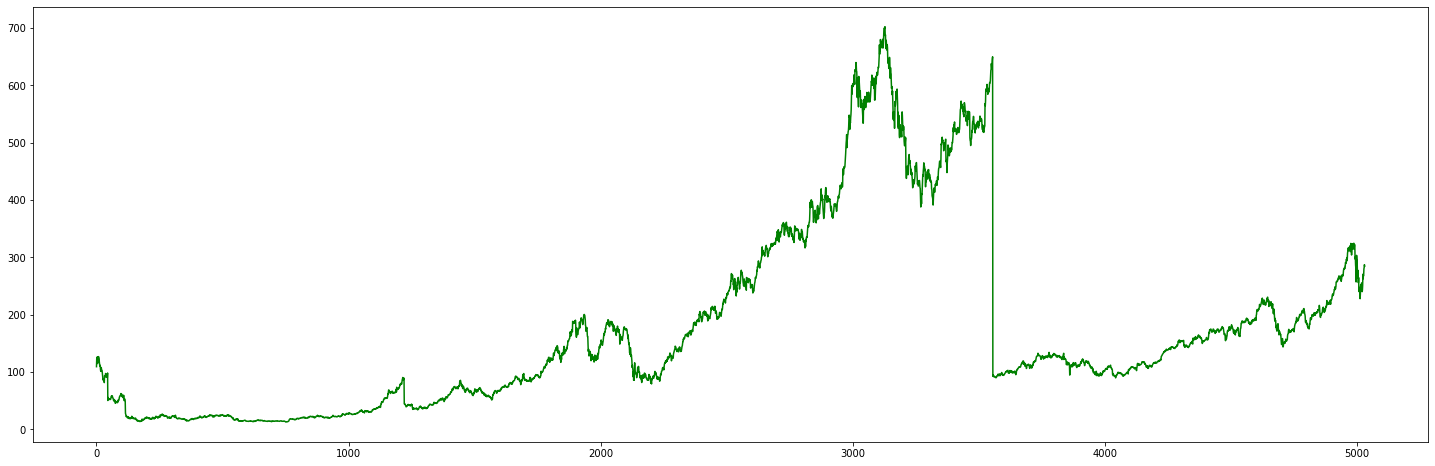

In [0]:
plt.figure(figsize=(25,8))
plt.plot(dataset['1. open'],color='green')

We are trying to predict the trend in last 60days, 
Please find below for the actual trend in last 60 days

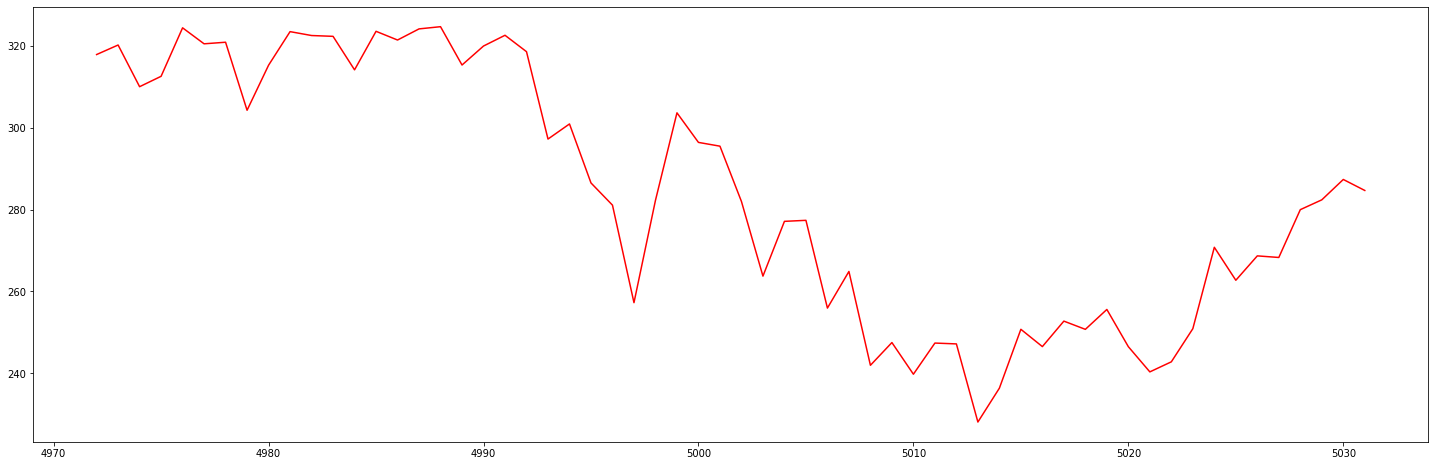

In [0]:
plt.figure(figsize=(25,8))
plt.plot(dataset.iloc[-60:,1:2],color='red')

In [0]:
dataset.head()

index  1. open  2. high  3. low  4. close  5. volume
0  2000-04-17   109.50   123.94  109.06    123.87  3656800.0
1  2000-04-18   123.50   126.87  119.37    126.87  3490400.0
2  2000-04-19   126.19   130.25  119.75    121.12  4644200.0
3  2000-04-20   123.69   124.75  117.06    118.87  6447500.0
4  2000-04-24   115.00   120.50  114.75    120.50  3960900.0

Creating the train and test data from the original dataset

In [0]:
dataset_train = dataset.iloc[:4971,:]

In [0]:
dataset_test = dataset.iloc[-60:,:]

In [0]:
print(dataset_train.shape,dataset_test.shape)

(4971, 6) (60, 6)


To create a numpy array of train values

In [0]:
train = dataset_train.iloc[:,1:2].values

We have a numpy array of one column

In [0]:
train[:10]

array([[109.5 ],
       [123.5 ],
       [126.19],
       [123.69],
       [115.  ],
       [122.12],
       [126.62],
       [117.19],
       [127.12],
       [124.87]])

## **Feature Scaling**

In [0]:
scale = MinMaxScaler(feature_range=(0,1))

In [0]:
train_scaled = scale.fit_transform(train)

In [0]:
train_scaled[:10]

array([[0.13998724],
       [0.16029416],
       [0.16419599],
       [0.16056975],
       [0.14796496],
       [0.15829248],
       [0.1648197 ],
       [0.15114154],
       [0.16554495],
       [0.16228134]])

## **Creating a training data structure** 

This means that model is going to take 120 stock prices before time T in which RNNs are going to learn and understand some correlations and based on its understanding its going to predict the next output

We can try the above by considering different timestamps

In [0]:
time_len = 120

In [0]:
X_train = []
y_train = []
for i in range(time_len,dataset_train.shape[0]):
    X_train.append(train_scaled[i-time_len:i,0])
    y_train.append(train_scaled[i,0])
X_train,y_train = np.array(X_train),np.array(y_train) #converting to numpy arrays so that they can be accepted in futute to our RNNs

X_train will contain the 120 previous stock prices for current financial day.

y_train will contain will contain stock price for current financial day

In [0]:
print(X_train[0],y_train[0])

[0.13998724 0.16029416 0.16419599 0.16056975 0.14796496 0.15829248
 0.1648197  0.15114154 0.16554495 0.16228134 0.15993154 0.1536799
 0.14813902 0.14188738 0.14374402 0.14116214 0.13209654 0.12819471
 0.1349105  0.13789852 0.13276377 0.13145833 0.13055902 0.12511967
 0.11714195 0.11242784 0.10617621 0.10952685 0.1088016  0.10825041
 0.10716254 0.09973601 0.11714195 0.11650373 0.11456006 0.11695338
 0.12275536 0.12149343 0.12094224 0.11342868 0.11850541 0.11351571
 0.11677932 0.11251487 0.12403179 0.05440805 0.06202315 0.05916568
 0.05730904 0.05916568 0.05848394 0.05812132 0.0577587  0.05677236
 0.05839691 0.05730904 0.05743959 0.05961533 0.06383627 0.06547533
 0.06601201 0.06402483 0.06564939 0.06601201 0.06121087 0.06093528
 0.06000696 0.05739607 0.05413246 0.05345073 0.05368281 0.05698993
 0.05246439 0.05413246 0.05223231 0.04724261 0.05291404 0.05060776
 0.05069479 0.05097038 0.05078182 0.04909924 0.05018711 0.04969395
 0.04915726 0.051333   0.05568449 0.05404543 0.05459662 0.05581

We can see our dataframe with 120 previews of previous stock of the taken financial day

We need to create the new dimensionality of the above mentioned new data structure, because that exactly is accepted by the future recurrent network. [Reference](https://keras.io/layers/recurrent/)

In [0]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

## **Model**

We will build our model below :

Since capturing the trends of a stock price is complex, we need to have high number of neurons

In [0]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 50)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 120, 50)           20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 120, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 120, 50)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)               

In [0]:
model.compile(optimizer='RMSProp',loss='mean_squared_error')

RMSProp optimizer is preferred for RNNs [Reference](https://keras.io/optimizers/)

In [0]:
history = model.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
4851/4851 [==============================] - 44s 9ms/step - loss: 0.0085
Epoch 2/20
4851/4851 [==============================] - 46s 9ms/step - loss: 0.0040
Epoch 3/20
4851/4851 [==============================] - 43s 9ms/step - loss: 0.0032
Epoch 4/20
4851/4851 [==============================] - 40s 8ms/step - loss: 0.0028
Epoch 5/20
4851/4851 [==============================] - 40s 8ms/step - loss: 0.0025
Epoch 6/20
4851/4851 [==============================] - 41s 8ms/step - loss: 0.0021
Epoch 7/20
4851/4851 [==============================] - 40s 8ms/step - loss: 0.0020
Epoch 8/20
4851/4851 [==============================] - 41s 8ms/step - loss: 0.0018
Epoch 9/20
4851/4851 [==============================] - 41s 8ms/step - loss: 0.0018
Epoch 10/20
4851/4851 [==============================] - 41s 8ms/step - loss: 0.0016
Epoch 11/20
4851/4851 [==============================] - 41s 8ms/step - loss: 0.0016
Epoch 12/20
4851/4851 [==============================] - 40s 8ms/step - lo

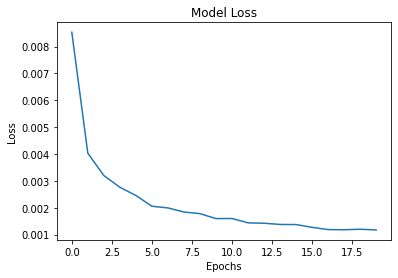

In [0]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

Here we can visualize that the model's loss decreases in an exponential way as the epochs increase

## **Creating a test data structure - LSTM**

Get the real stock price from testing dataset and convert it to numpy array

In [0]:
real_stock_price = dataset_test.iloc[:,1:2].values

We trained our model in such a way that it can predict the stock price at time T, based on 120 previous stock prices.

Therefore to predict stock prices for last 60days, we will need the 120 previous stock prices of the 60 previous financial days.

In [0]:
dataset_total = pd.concat((dataset_train['1. open'],dataset_test['1. open']),axis=0)

In [0]:
inputs = dataset_total[len(dataset_total)-len(dataset_test)-120:].values

In [0]:
inputs.shape

(180,)

As mentioned above we have to change the input shape

In [0]:
inputs = inputs.reshape(-1,1)

In [0]:
inputs.shape

(180, 1)

As done before we are doing feature scaling for the this data too.

In [0]:
inputs = scale.transform(inputs)

Creating X_test datastructure similar to X_train

In [0]:
X_test = []
for i in range(120,120+60):
    X_test.append(inputs[i-120:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

## **Prediction-LSTM**

In [0]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scale.inverse_transform(predicted_stock_price) #inversing the scaling

## **Visualizing the results-LSTM**

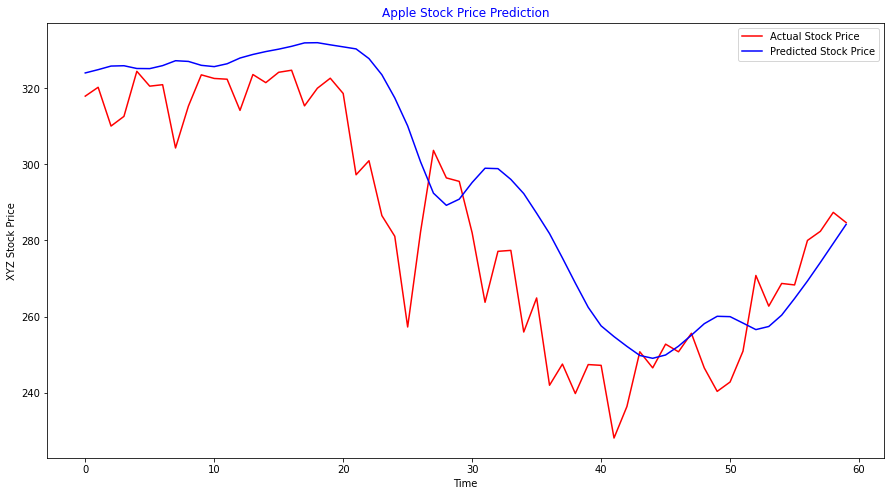

In [0]:
plt.figure(figsize=(15,8))
plt.plot(real_stock_price,color='red',label='Actual Stock Price')
plt.plot(predicted_stock_price,color='blue',label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction',color='blue')
plt.xlabel('Time')
plt.ylabel('XYZ Stock Price')
plt.legend()
plt.show()

The RNN we built was a regressor. Indeed, we were dealing with Regression because we were trying to predict a continuous outcome (the Apple Stock Price). For Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.

However for our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we donâ€™t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price.

## **LICENSE**

Copyright 2020 Ikyath Varma Dantuluri

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.